In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm # Not necessary to install - just does loading bars
import warnings
warnings.filterwarnings('ignore')
from stock_utils_updated import load_data, mean_variance_optimisation

TRADING_DAYS = 252
INTEREST_RATE = 0.02

SMALL, MED, LARGE = 18, 24, 30
LW = 2
plt.rc('xtick',labelsize=SMALL)
plt.rc('ytick',labelsize=SMALL)

# Modern Portfolio Theory

Before we can do any optimisation, we need to load the data.

In [2]:
shares = ['CAT', 'SUN', 'NAB', 'IAG', 'LFG', 'ELD', 'MND', 'VEA', 'PGH', 'PPE', 'NCK', 'ADH', 
          'BLX', 'KGN', 'JBH', 'DMP', 'ING', 'CKF', 'CLV', 'SHL', 'SFC', 'EHL', 'BKW', 'ASB', 
          'AZJ', 'REA', 'ZNO', 'NXT', 'IRE', 'ALU', 'WTC', 'HLS', 'XRO', 'CAR', 'RKN', 'CI1', 
          'APX']

siif_shares = ['ELD', 'LFG', 'NAB', 'SFC', 'BKW', 'ALU', 'CI1', 'CAT']

# SIIF invested on 2021-04-23
historical = load_data(shares, start='2018-01-01', end='2021-04-22')
daily = load_data(shares,  start='2021-04-23')
ndq   = load_data(['NDQ'], start='2021-04-23')

returns = historical.pct_change().dropna()

  0%|                                                                                           | 0/37 [00:00<?, ?it/s]

Loading Data


  3%|██▏                                                                                | 1/37 [00:00<00:06,  5.50it/s]

Loading Data


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.57it/s]

Loading Data


# Markowitz Mean-Variance Portfolio Theory

With a given choice of assets, we wish to determine the optimal weighting of investment allocation. For a given expected rate of return, we define the optimal portfolio to be the one that minimises the portfolio's variance/volatility.

Suppoe we have $n$ assets to choose from, we define a portfolio with a weight vector $w \in \mathbb{R}^n$, where each element $w_i \in [0, 1]$ represents the proportion of capital dedicated to the $i^{\text{th}}$ asset. Note that this means that $\sum_{i=1}^n{w_i} = \boldsymbol{1}^Tw = 1$.

If the ratio of an asset's value from one day to the previous is $R_i = \frac{x_1}{x_0}$, then the daily rate of return is $R_i - 1$, and the annual rate of return is $r_i = 252\times(R_i-1)$ (since there are $252$ trading days in a year). (Note that this notebook does not use the exact ratio between closing prices, but instead utilises adjusted closing prices. These prices are adjusted to include dividends and stock splits which more accurately represent the real value over the long term).

If $r = (r_1, r_2,..., r_3)^T$, then the expected annual rate of return for each asset is given in $\mu = E[r]$ with $\Sigma = $ cov$(r)$. This means that the expected rate of return for a given portfolio is $\mu^Tw$. The variance of this portfolio will be var$(r^Tw) = w^T\Sigma w$.

## The Optimisation Problem
We will set a minimum expected rate of return $b$ such that $\mu^Tw \geq b$.
The optimisation problem is:

$$\min \frac{1}{2}w^T\Sigma w$$
$$\text{s.t.  } \boldsymbol{1}^Tw = 1$$
$$w \geq 0$$
$$\mu^Tw \geq b$$

Or in plain English:
Minimise our portfolio's volatility given that we want an expected rate of return of at least $b$.

In [4]:
b_val = 0.3

And lastly, there is one more problem before we start investing, and that is the cost of investing. Unfortunately we cannot add a constraint to our optimisation program to tell the algorithm that we want to limit the number of investments. That's because this would make the optimisation NP-hard i.e. computationally infeasible. However, we can run an approximate algorithm to get close to the true answer. Essentially, you set a maximum number of assets that you wish to invest in (e.g. 10), and the algorithm will repeatedly trim away the least weighted assets in the optimal portfolio until only the desired number is reached.

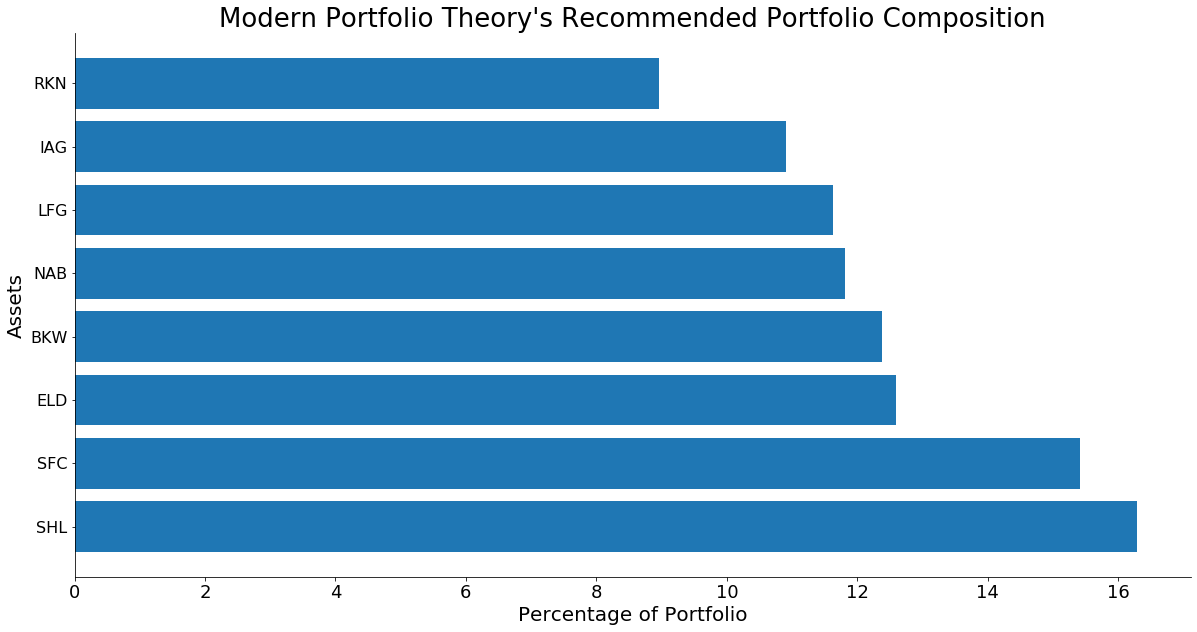

In [16]:
max_assets = 8
ret = returns.copy()
curr_size = len(ret.columns)

while curr_size > max_assets:
    var, w = mean_variance_optimisation(ret, b_val=b_val)
    # Get indexes of assets that were used in at least 0.1% of the portfolio
    indexes = [i for i in range(len(w)) if w[i] > 0.001]
    ret = ret.iloc[:, indexes]
    
    if len(ret.columns) == curr_size:
        # Remove smallest contributer
        ret = ret.drop(ret.columns[list(w).index(min(w))], axis=1)
        
    curr_size = len(ret.columns)
    
# Final optimisation with chosen assets
var, w = mean_variance_optimisation(ret, b_val=b_val)
mpt_composition = sorted(zip(w, ret.columns))

# Chart Portfolio Composition
fig, ax = plt.subplots(figsize=(20, 10))

assets = [e[1] for e in mpt_composition]
y_pos = np.arange(len(assets))
weights = [100*e[0] for e in mpt_composition]

ax.barh(y_pos, weights, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(assets, fontsize=16)
ax.invert_yaxis()
ax.set_xlabel('Percentage of Portfolio', fontsize=20)
ax.set_ylabel('Assets', fontsize=20)
ax.set_title('Modern Portfolio Theory\'s Recommended Portfolio Composition', fontsize=26)
sns.despine()
plt.show()

In [9]:
var, w = mean_variance_optimisation(returns[siif_shares], b_val=b_val)
mpt_siif_composition = sorted(zip(w, siif_shares))

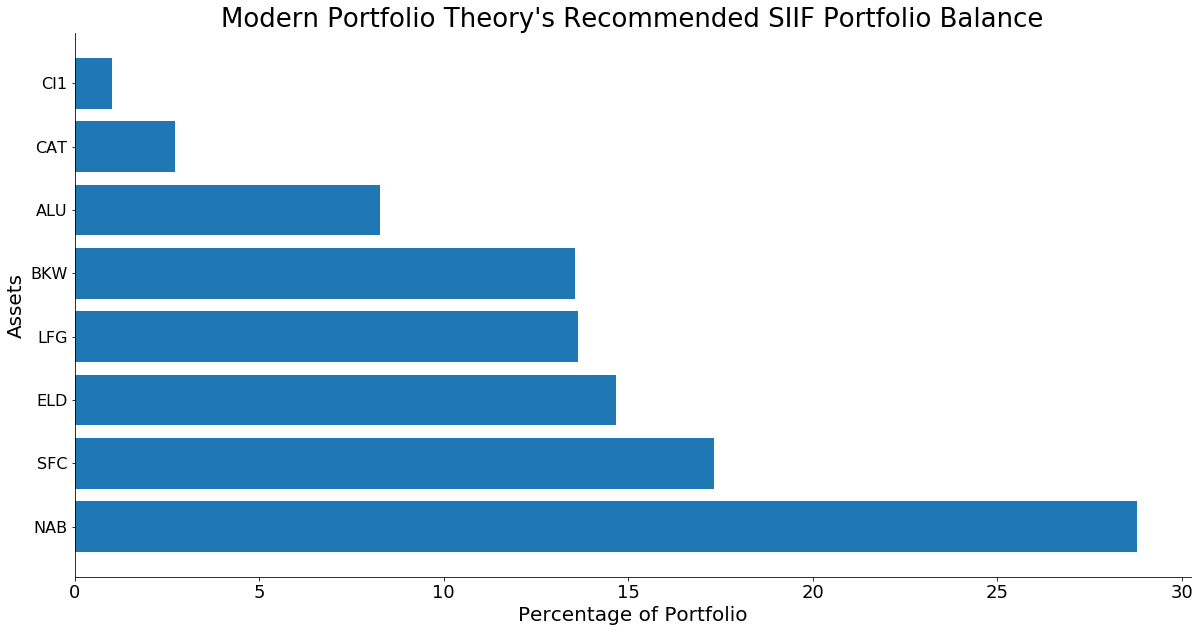

In [15]:
# Chart Portfolio Composition
fig, ax = plt.subplots(figsize=(20, 10))

y_pos = np.arange(len(siif_shares))
weights = [100*e[0] for e in mpt_siif_composition]

ax.barh(y_pos, weights, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels([e[1] for e in mpt_siif_composition], fontsize=16)
ax.invert_yaxis()
ax.set_xlabel('Percentage of Portfolio', fontsize=20)
ax.set_ylabel('Assets', fontsize=20)
ax.set_title('Modern Portfolio Theory\'s Recommended SIIF Portfolio Balance', fontsize=26)
sns.despine()
plt.show()

In [20]:
siif_composition = [(1/8, code) for code in siif_shares]
mpt_siif_composition, mpt_composition, siif_composition

([(0.0102217102, 'CI1'),
  (0.0272575576, 'CAT'),
  (0.0826171321, 'ALU'),
  (0.1354578468, 'BKW'),
  (0.13643356, 'LFG'),
  (0.1467745323, 'ELD'),
  (0.173332994, 'SFC'),
  (0.2879046669, 'NAB')],
 [(0.0895534055, 'RKN'),
  (0.1091190144, 'IAG'),
  (0.1163235905, 'LFG'),
  (0.1181520342, 'NAB'),
  (0.1237579457, 'BKW'),
  (0.1259437631, 'ELD'),
  (0.1541983732, 'SFC'),
  (0.1629518734, 'SHL')],
 [(0.125, 'ELD'),
  (0.125, 'LFG'),
  (0.125, 'NAB'),
  (0.125, 'SFC'),
  (0.125, 'BKW'),
  (0.125, 'ALU'),
  (0.125, 'CI1'),
  (0.125, 'CAT')])